In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from XRD import crystal, Element, XRD
import sys
import os
from similarity import Similarity

#### The first job for the user is provide a crystallographic file that describes some crystal structure. Call the crystal module to create the structure.
- **Necessary conditions**:
    1. The file must be either **.cif** or **POSCAR** file
    2. If a cif file, the structure must either have **no occupancy**, full and partial occupancy are not yet suppored by XRD.

ex: crystal('filetype', 'filename')

In [2]:
# loading a structure via POSCAR file
struct = crystal('POSCAR',filename='POSCAR-NaCl')
print(type(struct))

# loading a structure via cif file
struct = crystal('cif',filename='NaCl.cif')

<class 'XRD.crystal'>


#### After computing the structure, the user can call XRD to obtain the XRD pattern.
- Three parameters must be specified:
    1. the structure, obtained above  (XRD.crystal)
    2. the wavelength of the xray source (in Angstroms) (float)
    3. the maximum measurement angle (int/float)
- The user could also specify whether or not they want to include preferred orientation (boolean)
    - If True, user will specify some float, between 0 and 1, for the calculation of PO
    - For now, it's best if don't include this into the website.
    
ex: XRD(struct, 1.54056, 90)

#### All XRD results are grouped by their equivalent hkl planes in the pxrdf method, and accessed by calling the XRD.pxrd method.
- In order, the results are (N*6) arrays, where N corresponds to a single plane and 6 corresponds to:
    1. angle
    2. d_hkl
    3. h
    4. k
    5. l
    6. intensity

In [3]:
xrd1 = XRD(struct, 1.54056, 90) 
theta2 = xrd1.pxrd[:,0]
intensity = xrd1.pxrd[:,-1]

#### Next, the user can apply a profiling function to their simulated XRD pattern. 
- When calling the get_profile method, the user must specify 3 arguments and a range of keyword arguments (denoted by **)
    1. theta values obtained from xrd simulation (arr)
    2. relative intensities obtained from xrd simulation (arr)
    3. resolution of profiling function/single dimension of profile (int)
    4. profiling (dictionary)

#### Profiling
- in all cases, the user can choose either a theta-dependent or independent profile
- if theta-dependent, the user must specify a series of parameters to calculate the profile's FWHM.
- if theta-independent, the user simply specifies the profile's FWHM.
- There are currently 3 profiling functions the user can choose from
    1. gaussian
    2. lorentzian
    3. split-type

##### Gaussian. 

In [4]:
# Theta-independent
prof_indep_g = {'function':'gaussian', 'FWHM': 0.05}
# Theta-dependent
prof_dep_g = {'function':'gaussian', 'V': 0.5}

##### Lorentzian
- similar to the gaussian howver, 'X' is called here instead of V.

In [5]:
# Theta-independent
prof_indep_l = {'function':'lorentzian', 'FWHM': 0.05}
# Theta-dependent
prof_dep_l = {'function':'lorentzian', 'X': 0.5}

##### Split-type

In [6]:
U = 5.776410E-03 # FWHM parameter, U
V = -1.673830E-03 # FWHM parameter, V
W = 5.668770E-03 # FWHM parameter, W
A = 1.03944 # Asymmetry parameter, a1
eta_h = 0.504656 # Mixing parameter, eta_H0
eta_l = 0.611844  # Mixing parameter, eta_L0

# Theta-independent, notice how FWHM is called after the function.
prof_indep_split = {'function':'split-type', 'FWHM': 0.05, 'A':A, 'eta_h':eta_h, 'eta_l':eta_l}
# Theta-dependent, difference from above in theta_dep, A, and eta values.
prof_dep_split = {'function':'split-type', 'theta_dependence': True, 'U': U, 'V':V, 
                  'W':W, 'A':A, 'eta_h':eta_h, 'eta_l':eta_l}

#### After deciding which profiling function the user would like to use, and correctly specifying the parameters per choice, the user can run the profiling function in the following way:

ex: xrd1.get_profile(theta2,intensity,10000,**profiling)

#### This will create a 2D array (called XRD.spectra) within XRD, of the profiling function, with thetas in the first dimension and intensities in the second.

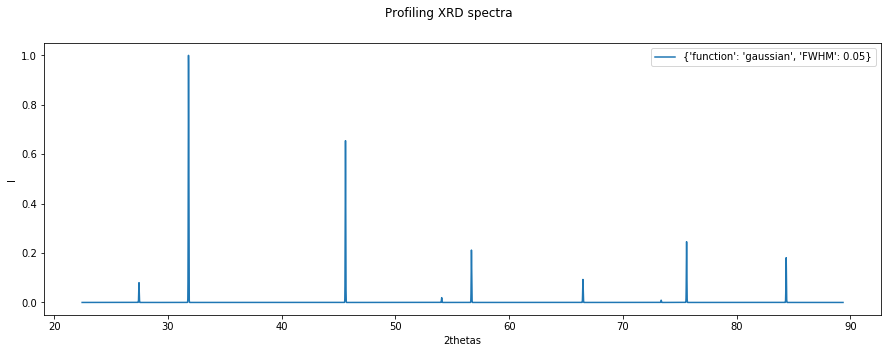

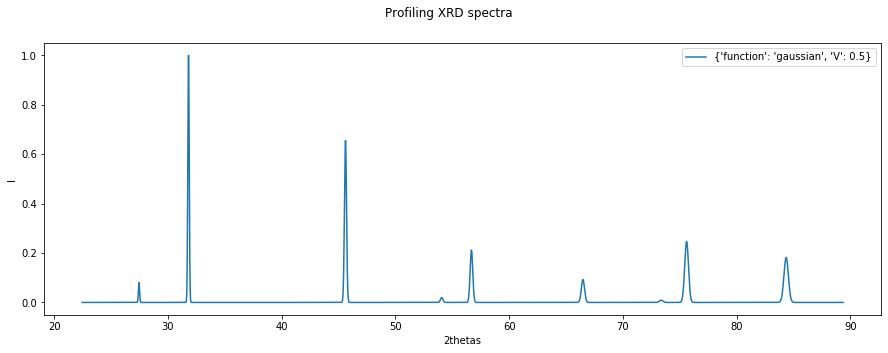

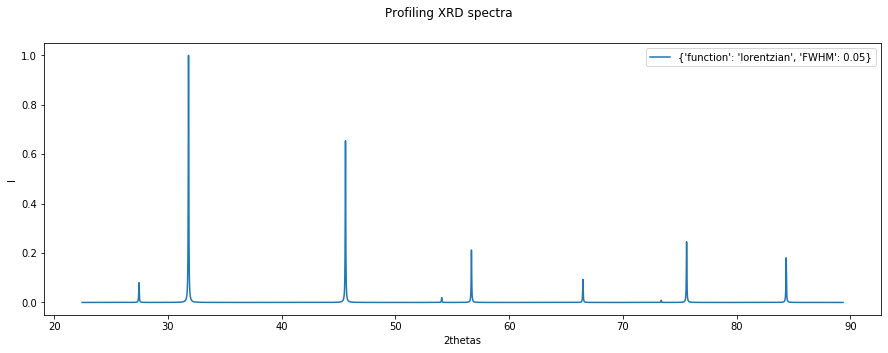

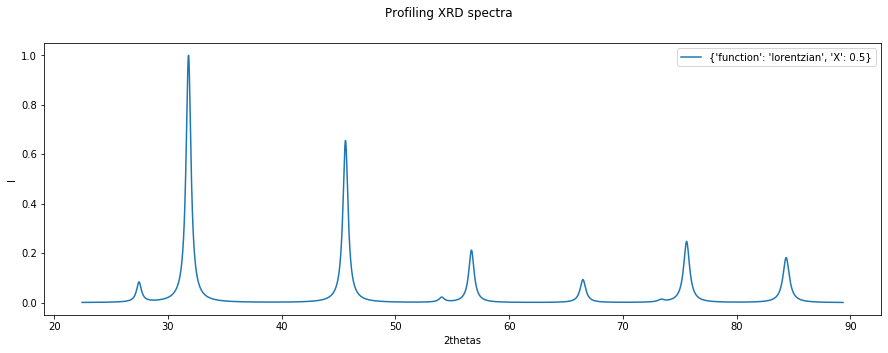

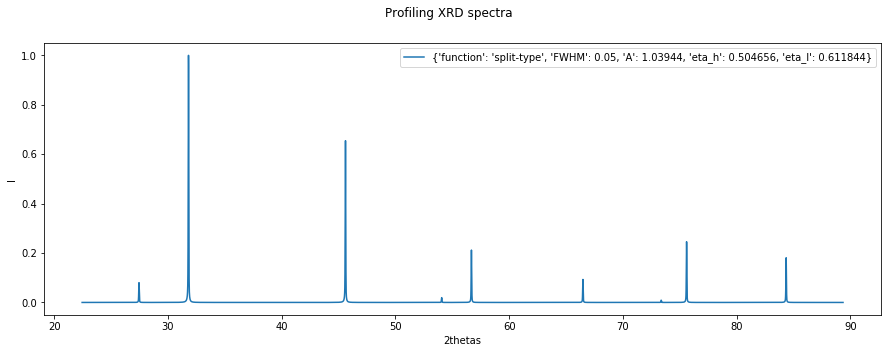

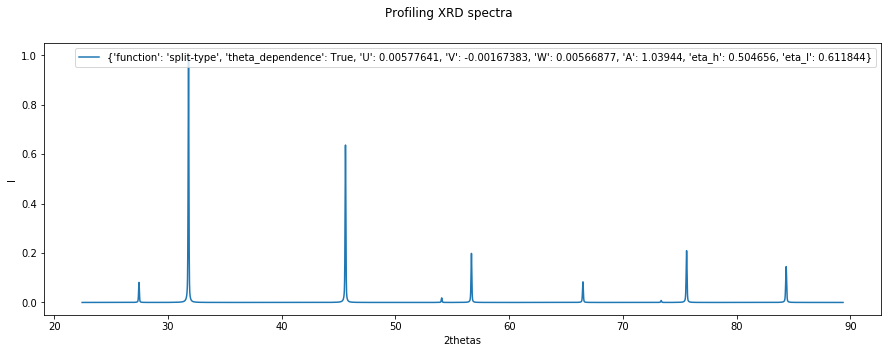

In [14]:
profiles =  [prof_indep_g,prof_dep_g,prof_indep_l,prof_dep_l,prof_indep_split,prof_dep_split]
# now you can choose from a list of different profiling functions, and plot them

for profile in profiles:
    plt.figure(figsize=(15,5))
    plt.suptitle('Profiling XRD spectra')
    plt.xlabel('2thetas')
    plt.ylabel('I')
    xrd1.get_profile(theta2,intensity,10000,**profile)
    pTheta2 = xrd1.spectra[0]
    pIntensity = xrd1.spectra[1]
    plt.plot(pTheta2,pIntensity,label=str(profile))
    plt.legend()
    plt.show()
